In [1]:
%matplotlib notebook

import numpy as np
import cv2
import os
import sys

sys.path.append('../functions/')
sys.path.append('../utils/')

from DoG import DoG
from file_manager import File_manager
from wdd_decoder_functions import create_diff_images, calculate_image_sum_for_frame, calculate_image_sum_for_angle


from matplotlib import pyplot as plt
from joblib import Parallel, delayed
from sklearn.linear_model import TheilSenRegressor
from skimage.transform import radon, rescale

from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal

<IPython.core.display.Javascript object>


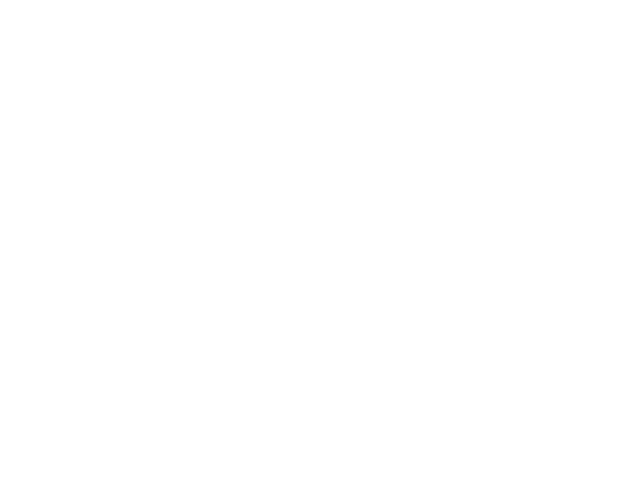

NameError: name 'td' is not defined


[[False False False ..., False False False]
 [False False False ..., False False False]
 [False False False ..., False False False]
 ..., 
 [False False False ..., False False False]
 [False False False ..., False False False]
 [False False False ..., False False False]]


<IPython.core.display.Javascript object>


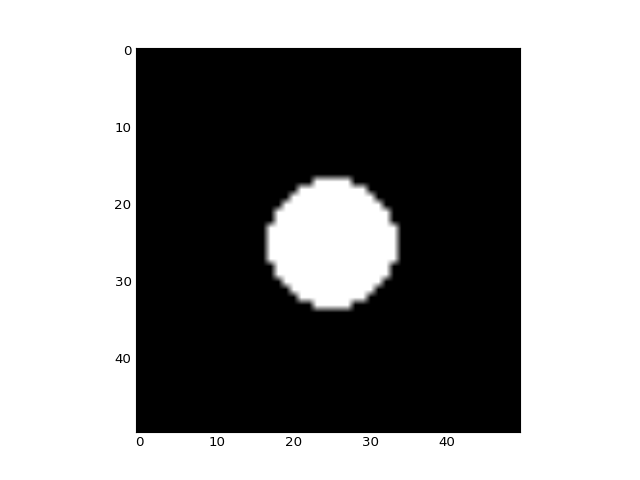

<function matplotlib.pyplot.show>

In [2]:
circle = np.zeros(shape=(50,50))
xx, yy = np.mgrid[:50, :50]

circle = (xx - 25) ** 2 + (yy - 25) ** 2
print()
donut = np.logical_and(circle < (8**2 + 6), circle >= (0))
print(donut)
plt.figure()
plt.imshow(donut,cmap=plt.cm.gray)
plt.show

In [6]:
%load_ext line_profiler

In [3]:
angles = np.arange(0, 360, 1)

angles.sort()

maxima = []
mean_val = []

cov_matrix = np.matrix([[6., 0],[0, 2.]])

smothing = np.matrix([[1,1,1],[1,1,1],[1,1,1]]) / 9

path = '/home/sascwitt/Projects/test/WDs/'
folders = os.listdir(path)
folders.sort()

In [8]:
dog = DoG().mexican_head_kernel

cov1 = 30 * np.eye(2)
cov2 = 4 * np.eye(2)

_dog = abs(np.fft.fftshift(np.fft.fft2(dog(50, [25,25], cov1, [25,25], cov2))))

<IPython.core.display.Javascript object>


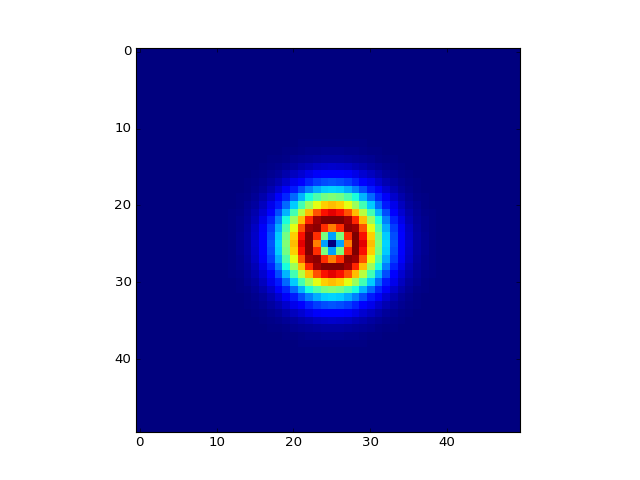

<function matplotlib.pyplot.show>

In [9]:
plt.figure()
plt.imshow(_dog, interpolation="nearest")
plt.show

In [9]:
fm_csv = File_manager("/home/sascwitt/Projects/test/WDs/").read_csv

In [10]:
diff_img = create_diff_images(path, folders)

In [11]:
fft_imgs = []
keys = []

for key, img_arrays in list(diff_img.items()):
    keys.append(key)
    image = None
    
    for img in img_arrays:
        tmp = np.fft.fftshift(abs(np.fft.fft2(img)))
        if image is None:
            image = tmp
        
        else:
            image += tmp
    
    fft_imgs.append(image)

In [12]:
print(keys[6])
plt.figure()
plt.imshow(fft_imgs[6])
plt.show()

/home/sascwitt/Projects/test/WDs/20160814_1002_1/23/


<IPython.core.display.Javascript object>

In [13]:
error = []

for index, image in enumerate(fft_imgs):
    dog_filtered = np.multiply(image, td)
    
    powered_dog = np.power(dog_filtered, 5)
    
    moment = cv2.moments(powered_dog)
    img_cov = np.array([[moment['m20'], moment['m11']], [moment['m11'], moment['m02']]])
    
    w,v = np.linalg.eig(img_cov)
    
    calc_angle = np.arctan2(v[1][1], v[1][0]) * 180 / np.pi
    
    gt_angle = float(fm_csv(keys[index] + "result.csv")["Angle"])
    
    error.append(calc_angle - gt_angle)

NameError: name 'td' is not defined

In [120]:
for idx, i in enumerate(error):
    if i > 180:
        error[idx] = i - 360
    
    if i < -180:
        error[idx] = i + 360
        
    if error[idx] > 90:
        error[idx] -= 180
        
    if error[idx] < -90:
        error[idx] += 180

(50, 50)


<IPython.core.display.Javascript object>


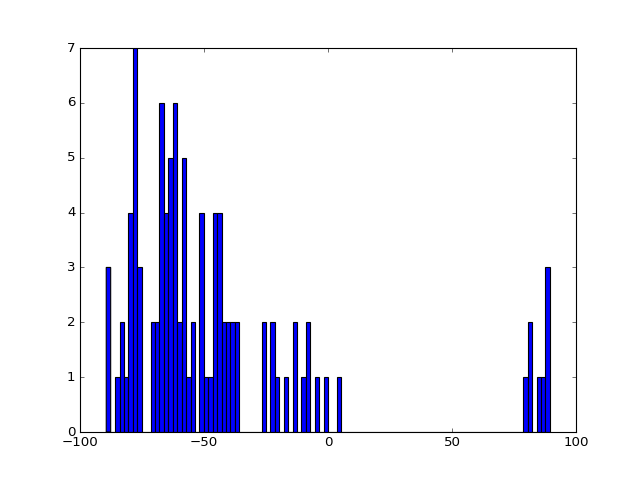

In [121]:
print(fft_imgs[1].shape)
plt.figure() 
plt.hist(error, bins=100)
plt.show()

In [110]:
def img_moments(image, p, q):
    height, width = image.shape
    center_x = width / 2 + 1
    center_y = height / 2 + 1
    
    x = np.arange(0, width)
    y = np.arange(0, height)

    X = np.power((x - center_x), p)
    Y = np.power((y - center_y), q)
    #print(Y)
    
    t1 = np.transpose(X) * Y
    
    print(t1)
    return sum(sum(np.multiply(t1, image)))

In [122]:
m00 = img_moments(fft_imgs[0], 0, 0)
m11_ = img_moments(fft_imgs[0], 1, 1) / m00
m02_ = img_moments(fft_imgs[0], 0, 2) / m00
m20_ = img_moments(fft_imgs[0], 2, 0) / m00
img_cov = np.array([[m20_, m11_], [m11_,m02_]])

print(img_cov.shape)
print(img_cov)
w,v = np.linalg.eig(img_cov)
print(v)
print(np.arctan2(v[1][1], v[1][0]) * 180 / np.pi)

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
[ 676.  625.  576.  529.  484.  441.  400.  361.  324.  289.  256.  225.
  196.  169.  144.  121.  100.   81.   64.   49.   36.   25.   16.    9.
    4.    1.    0.    1.    4.    9.   16.   25.   36.   49.   64.   81.
  100.  121.  144.  169.  196.  225.  256.  289.  324.  361.  400.  441.
  484.  529.]
[ 676.  625.  576.  529.  484.  441.  400.  361.  324.  289.  256.  225.
  196.  169.  144.  121.  100.   81.   64.   49.   36.   25.   16.    9.
    4.    1.    0.    1.    4.    9.   16.   25.   36.   49.   64.   81.
  100.  121.  144.  169.  196.  225.  256.  289.  324.  361.  400.  441.
  484.  529.]
[ 676.  625.  576.  529.  484.  441.  400.  361.  324.  289.  256.  225.
  196.  169.  144.  121.  100.   81.   64.   49.   36.   25.   16.    9.
    4.    1.    0.    1.    4.    9.  